# Inspecting Iodine molecule spectre

In [20]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import chisquare

## Импортируем данные
Данные разделены на два DataFrame: `data` и `data_long`.

`data_long` содержит данные одного эксперимента: расширенный диапазон длин волн:
от 340 до 700 нм

`data` содержит совокупные данные остальных экспериментов в длинной форме.

Столбцы Фреймов:
- `Wavelength` [float] - длина волны, абсцисса измерений, **в нм**
- `Transmission` [float] - пропускание, ордината измерений, **в %**
- `Temperature` [int] - температура капсулы с иодом, при которых проводились измерения, **в градусах Цельсия**. *Примечание: возможно на 1-2 градуса отличается от реальных значений температуры.*
- `Slit` [float] - толщина щели интерферометра, **в нм (или мкм?)**

In [21]:
data = pd.DataFrame(columns=['Wavelength', 'Transmission'])
for name in ('40', '50', '60'):
    df = pd.read_csv(
        name+'.dat', sep=' ', skiprows=1, decimal=','
    )[['nm', '%']].rename({'nm': 'Wavelength', '%': 'Transmission'}, axis=1)
    df['Temperature'] = int(name)
    df['Slit'] = 0.1
    data = pd.concat((data, df), axis=0)
for name in ('0.1', '0.5', '1', '5'):
    df = pd.read_csv(
        '70 ' + name + '.dat', sep=' ', skiprows=1, decimal=','
    )[['nm', '%']].rename({'nm': 'Wavelength', '%': 'Transmission'}, axis=1)
    df['Temperature'] = 70
    df['Slit'] = float(name)
    data = pd.concat((data, df), axis=0)
data_long = pd.read_csv(
        '70 340-700.dat', sep=' ', skiprows=1, decimal=','
    )[['nm', '%']].rename({'nm': 'Wavelength', '%': 'Transmission'}, axis=1)
data_long['Temperature'] = 70
data_long['Slit'] = 0.1
del df
data.head()


,Wavelength,Transmission,Temperature,Slit
0,480.0,69.243546,40.0,0.1
1,480.2,69.101525,40.0,0.1
2,480.4,69.233954,40.0,0.1
3,480.6,69.150352,40.0,0.1
4,480.8,69.139163,40.0,0.1


## Строим полученные спектры
Строим зависимости пропускания `Transmission` от длины волны `Wavelength`

<Axes: xlabel='Wavelength', ylabel='Transmission'>

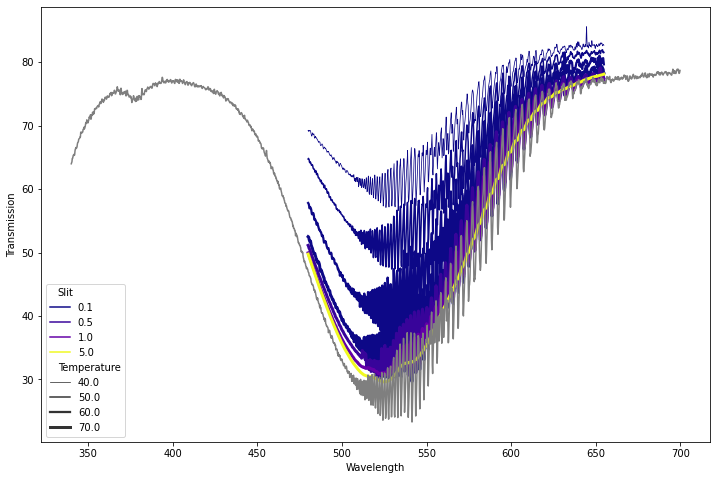

In [22]:
funny = [(i, 0.1) for i in range(40, 71, 10)] + [(70, i) for i in (0.5, 1, 5)]
plt.figure(figsize=(12, 8))
sns.lineplot(
    data = data,
    x = 'Wavelength',
    y = 'Transmission',
    size = 'Temperature',
    hue = 'Slit',
    palette='plasma'
)
sns.lineplot(data_long, x='Wavelength', y='Transmission')

Сделать три разных графика со спектрами:
- [ ] Длинный спектр в одиночку
- [ ] Постоянная температура, разная ширина щели
- [ ] Постоянная ширина щели, разная температура

### Длиннный спектр в одиночку

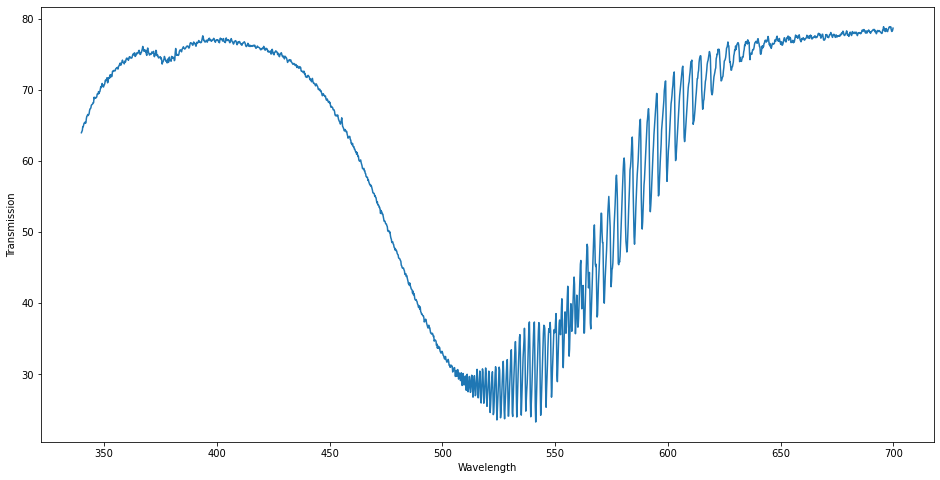

In [23]:
plt.figure(figsize=(16, 8))
sns.lineplot(data_long, x='Wavelength', y='Transmission')
plt.savefig('long.jpg')

### Спектры с постоянной температурой

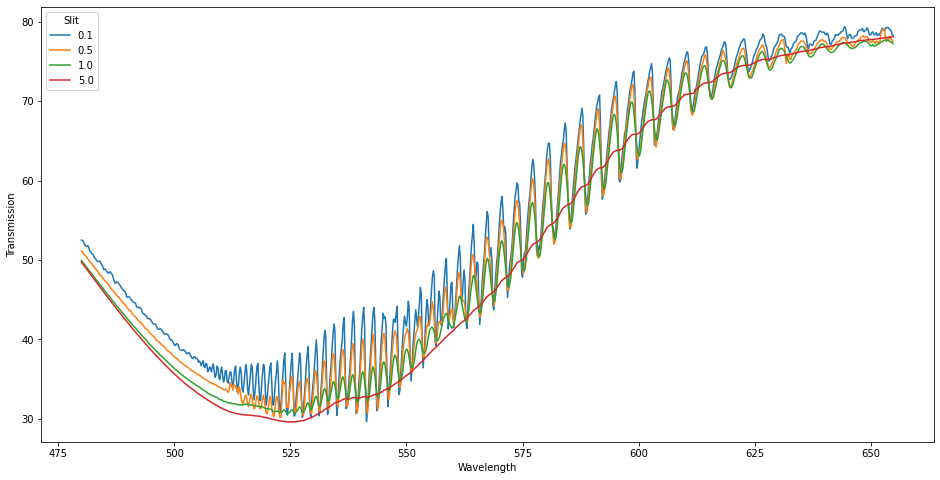

In [24]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=data[data['Temperature'] == 70],
    x='Wavelength',
    y='Transmission',
    hue='Slit',
    palette='tab10'
)
plt.savefig('changing slit.jpg')

### Спектры с постоянной шириной щели

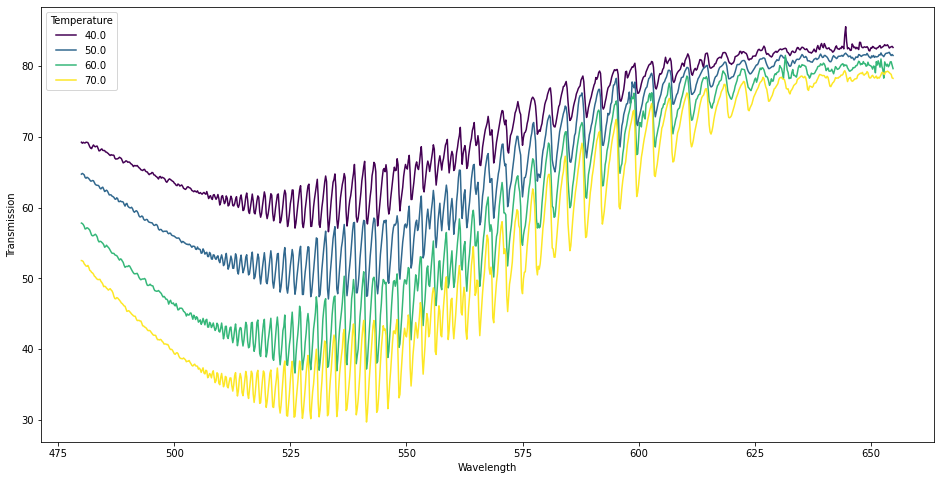

In [25]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=data[data['Slit'] == 0.1],
    x='Wavelength',
    y='Transmission',
    hue='Temperature',
    palette='viridis'
)
plt.savefig('changing temperature.jpg')

(500.0, 620.0)

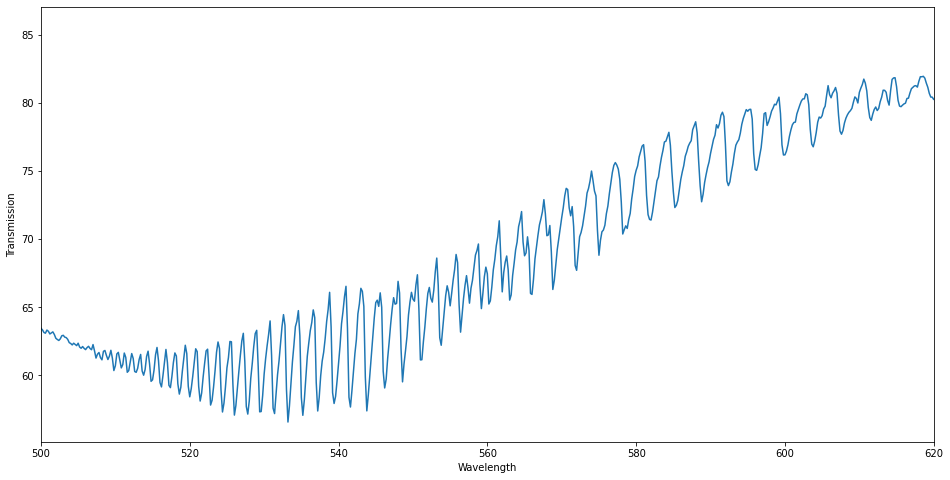

In [26]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data = data[data['Temperature'] == 40],
    x = 'Wavelength',
    y = 'Transmission',
)
plt.xlim(500, 620)
# sns.lineplot(data_long, x='Wavelength', y='Transmission')

## Выбираем в спектрах локальные минимумы
С помощью функции `argrelextrema` находим верхние и нижние пики на спектре.

Поиск пиков происходит в диапазоне длин волн от 505 до 630 нм.
Данные сохраняются в DataFrame `df`

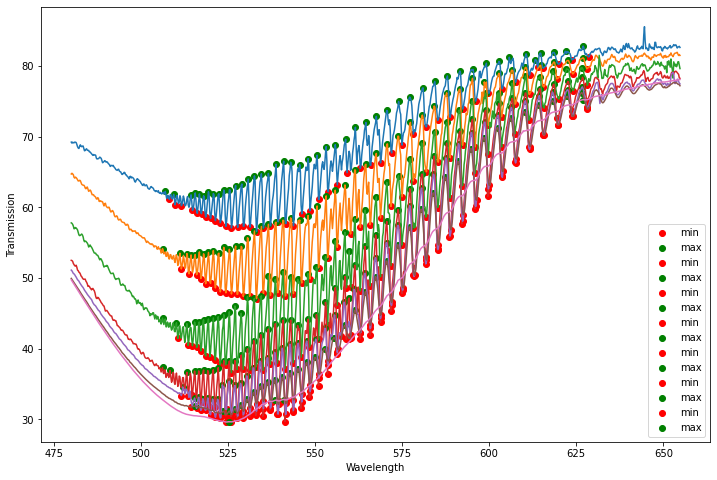

In [27]:
from scipy.signal import argrelextrema

n = 5  # number of points to be checked before and after
plt.figure(figsize=(12, 8))

for temp, slit in funny:
    df = data[(data['Temperature'] == temp) & (data['Slit'] == slit)]

    df['min'] = df.loc[argrelextrema(df['Transmission'].values, np.less_equal,
                        order=n)[0]]['Transmission'][
        (df['Wavelength'] > 505) & (df['Wavelength'] < 630)
    ]
    df['max'] = df.loc[argrelextrema(df['Transmission'].values, np.greater_equal,
                        order=n)[0]]['Transmission'][
        (df['Wavelength'] > 505) & (df['Wavelength'] < 630)
    ]
    plt.scatter(data = df, x='Wavelength', y='min', c='r')
    plt.scatter(data = df, x='Wavelength', y='max', c='g')
    sns.lineplot(data = df, x='Wavelength', y='Transmission')

# Plot results

Для спектра, полученного при температуре 40°С, отдельно рассмотрим минимумы, и пронумеруем их как на примере

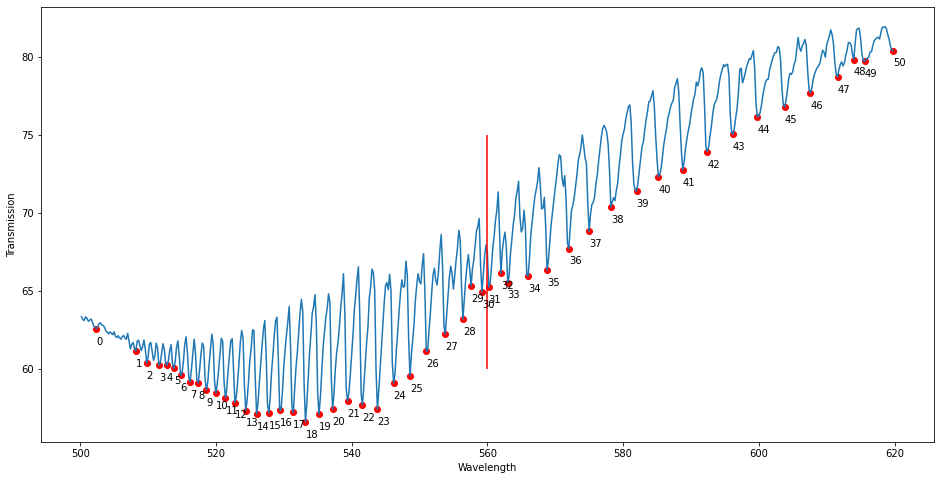

In [28]:
plt.figure(figsize=(16, 8))

spectre = data[(data['Temperature'] == 40)
               & (data['Wavelength'] > 500)
               & (data['Wavelength'] < 620)].copy().reset_index()

sns.lineplot(spectre, x='Wavelength', y='Transmission')

spectre['min'] = spectre.loc[argrelextrema(spectre['Transmission'].values, np.less_equal,
                        order=4)[0]]['Transmission']
mins = spectre.dropna(axis=0, how='any', subset=['min'])[['Wavelength', 'Transmission']].reset_index()

plt.scatter(data=mins, x='Wavelength', y='Transmission', color='red', label='min')
for i, row in mins.iterrows():
    plt.text(x=row['Wavelength'], y=row['Transmission']-1, s=i)
plt.vlines(x=560, ymin=60, ymax=75, color='r')

Добавляем подписи к пикам соответсвующих последовательностей

559.200000000009 0


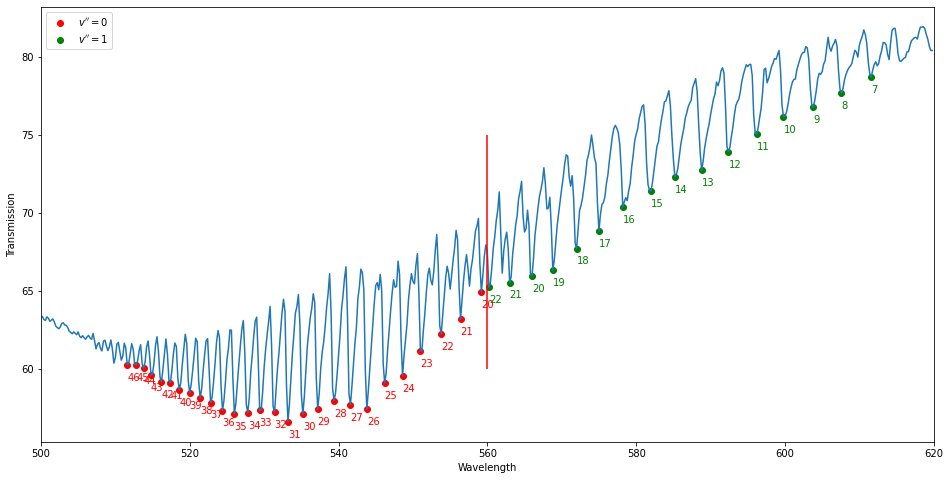

In [29]:
mins = spectre.dropna(axis=0, how='any', subset=['min'])[['Wavelength', 'Transmission']].reset_index()
mins1 = mins.loc[(list(range(3, 29))+[30])[::-1]].reset_index()
mins2 = mins.loc[([31]+list(range(33, 48)))[::-1]].reset_index()
for i, row in mins1.iterrows():
    print(row['Wavelength'], i)
    break
# mins1
mins1['nu'] = range(20, 47)
mins2['nu'] = range(7, 23)

mins1['v'] = 1e7/mins1['Wavelength']
mins2['v'] = 1e7/mins2['Wavelength']

plt.figure(figsize=(16, 8))
sns.lineplot(spectre, x='Wavelength', y='Transmission')

plt.scatter(data=mins1, x='Wavelength', y='Transmission', color='r', label="$v''=0$")
for i, row in mins1.iterrows():
    plt.text(x=row['Wavelength'], y=row['Transmission']-1, s=int(row['nu']), color='r')

plt.scatter(data=mins2, x='Wavelength', y='Transmission', color='g', label="$v''=1$")
for i, row in mins2.iterrows():
    plt.text(x=row['Wavelength'], y=row['Transmission']-1, s=int(row['nu']), color='g')

plt.vlines(x=560, ymin=60, ymax=75, color='r')
plt.xlim(500, 620)
plt.legend()

plt.savefig('mins.jpg')

## Анализируем данные локальных минимумов

Построим по имеющимся данным о минимумах Таблицу Деландра

In [30]:
pd.merge(mins1, mins2, 'outer', 'nu').sort_values('nu')[
    ['nu', 'Wavelength_x', 'v_x', 'Wavelength_y', 'v_y']
].to_latex(
    'Delander.tex',
    index=False, na_rep='', caption='Таблица Деландра',
    formatters={
        'Wavelength_x': '{:.1f}'.format,
        'Wavelength_y': '{:.1f}'.format,
        'v_x': '{:.4g}'.format,
        'v_y': '{:.4g}'.format,
    }
)

Будем аккуратно хранить все данные в удобной структуре `Data`

In [31]:
class Value:
    def __init__(self, name: str, value: float, err:float =0) -> None:
        self.name = name
        self.value = value
        self.err = err
    
class Data:
    def __init__(self):
        self.values = {}
    
    def add(self, name, value, err=0):
        self.values[name] = Value(name, value, err)
    
    def __getitem__(self, name):
        v = self.values[name].value
        e = self.values[name].err
        return v, e, e/v
    
    def get_str(self, name):
        a, b, c = self[name]
        return name+' '+str(a)+' '+str(b)
    
    def __repr__(self) -> str:
        return '\n'.join([self.get_str(a) for a in self.values])

goals = Data()

def sq_sum(*argv):
    s = 0
    for item in argv:
        s += item**2
    return np.sqrt(s)

In [32]:
table1 = mins1[['nu', 'Wavelength', 'v']]
table2 = mins2[['nu', 'Wavelength', 'v']]

G1 = []
for i, row in table1.iterrows():
    if i == 0:
        prev = row
        continue
    G1.append(row['v'] - prev['v'])
    prev = row
G1.append(None)
table1['G'] = G1
G1 = []
for i, row in table2.iterrows():
    if i == 0:
        prev = row
        continue
    G1.append(row['v'] - prev['v'])
    prev = row
G1.append(None)
table2['G'] = G1
v_max = table1[table1['nu'] == 31].values[0][2]
v_max
goals.add('v_max', v_max)


Строим зависимость найденного $G$ от $\nu+1$

4295.166993247257


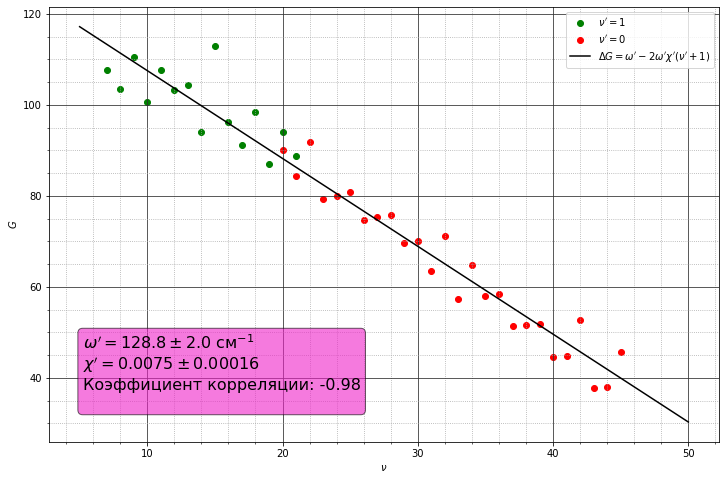

In [33]:
plt.figure(figsize=(12, 8))
ax = plt.axes()

plt.scatter(x=table2['nu'], y=table2['G'], color='g', label=r"$\nu'=1$")
plt.scatter(x=table1['nu'], y=table1['G'], color='r', label=r"$\nu'=0$")

plt.xlabel(r'$\nu$')
plt.ylabel(r'$G$')

table1['Prog'] = 0
table2['Prog'] = 1

table_all = pd.concat(
    (table1[['nu', 'v', 'G', 'Prog']], table2[['nu', 'v', 'G', 'Prog']]),
    axis=0
).dropna(axis=0)
f = lambda nu, omega, chi: omega-2*omega*chi*(nu+1)
popt, pcov = curve_fit(f, table_all['nu'], table_all['G'])
xs = np.linspace(5, 50)
ys = f(xs, *popt)
plt.plot(xs, ys, color='k', label = r"$\Delta G = \omega'-2\omega'\chi'(\nu'+1)$")

plt.legend()

omega1, chi1 = popt

goals.add('omega1', omega1, np.sqrt(pcov[0][0]))
goals.add('chi1', omega1, np.sqrt(pcov[1][1]))

props = dict(boxstyle='round', facecolor='#ef21c8', alpha=0.6)
text = """$\\omega' = {omega} \\pm {d_omega}$ см$^{p}$
$\\chi' = {chi} \\pm {d_chi}$
Коэффициент корреляции: {corr}
""".format(
    omega = round(popt[0], 1), d_omega=round(np.sqrt(pcov[0][0]), 1),
    chi = round(popt[1], 5), d_chi=round(np.sqrt(pcov[1][1]), 5),
    corr = round(np.corrcoef(x=table_all['nu'], y=table_all['G'])[0][1], 2),
    p=r'{-1}'
)
plt.text(0.05, 0.25, text, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

# Add grid (very nice looking one :D)
from matplotlib.ticker import MultipleLocator
plt.grid(which='major', color='#323232', linestyle='-')
plt.grid(which='minor', color='#a4a4a4', linestyle=':')
mlx = MultipleLocator(2)
ax.xaxis.set_minor_locator(mlx) 
mly = MultipleLocator(5)
ax.yaxis.set_minor_locator(mly)

D1 = omega1/(4*chi1)
goals.add(
    'D1',
    D1,
    (goals['omega1'][2]**2 + goals['chi1'][2]**2)**0.5 * D1
)

print(D1)
plt.savefig('G and nu+1.jpg')

15689.140791092132


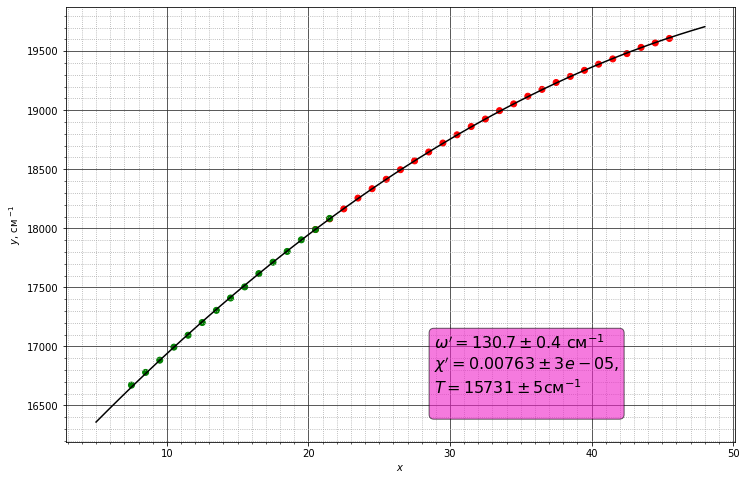

In [34]:
plt.figure(figsize=(12, 8))
ax = plt.axes()

maps = {0:'r', 1:'g'}

x = table_all['nu']+0.5
y = table_all['v'] + (0.5+table_all['Prog'])*214.5
color = table_all['Prog'].apply(lambda k: maps[k])
plt.scatter(x, y, c=color)

f2 = lambda x, T, omega, chi: T + omega*x - omega*chi*x**2

popt, pcov = curve_fit(f2, x, y, maxfev=10000, p0=(15800, 130, 0.008))

T2, omega2, chi2 = popt

goals.add('T2', T2, np.sqrt(pcov[0][0]))
goals.add('omega2', omega2, np.sqrt(pcov[1][1]))
goals.add('chi2', chi2, np.sqrt(pcov[2][2]))

xs = np.linspace(5, 48)
ys = f2(xs, *popt)

plt.plot(xs, ys, color='k')

props = dict(boxstyle='round', facecolor='#ef21c8', alpha=0.6)
text = """$\\omega' = {omega} \\pm {d_omega}$ см$^{p}$
$\\chi' = {chi} \\pm {d_chi}$,
$T = {T} \\pm {d_T} $см$^{p}$
""".format(
    omega = round(popt[1], 1), d_omega=round(np.sqrt(pcov[1][1]), 1),
    chi = round(popt[2], 5), d_chi=round(np.sqrt(pcov[2][2]), 5),
    T = round(popt[0]), d_T=round(np.sqrt(pcov[0][0])),
    p=r'{-1}',
    # chisq=round(chisquare(y, f2(x, *popt)).pvalue, 2)
)
plt.text(0.55, 0.25, text, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

# Add grid (very nice looking one :D)
from matplotlib.ticker import MultipleLocator
plt.grid(which='major', color='#323232', linestyle='-')
plt.grid(which='minor', color='#a4a4a4', linestyle=':')
mlx = MultipleLocator(1)
ax.xaxis.set_minor_locator(mlx) 
mly = MultipleLocator(100)
ax.yaxis.set_minor_locator(mly)

plt.xlabel('$x$')
plt.ylabel('$y$, см $^{-1}$')

nu00 = T2 + 0.5*omega2 - 0.5*214.5
goals.add(
    'nu00',
    nu00,
    sq_sum(goals['T2'][1], 0.5*goals['omega2'][1])
)
print(nu00)
plt.savefig('y and x.jpg')

4055.6665650286977


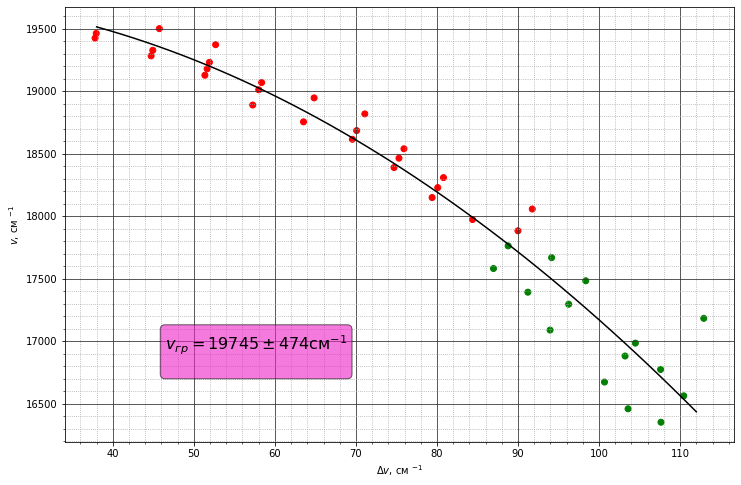

In [35]:
plt.figure(figsize=(12, 8))
ax = plt.axes()

maps = {0:'r', 1:'g'}

x = table_all['G']
y = table_all['v']
color = table_all['Prog'].apply(lambda k: maps[k])

popt, pcov = curve_fit(f2, x, y)

nugr, _, _ = popt

goals.add('nugr', nugr, np.sqrt(pcov[0][0]))

xs = np.linspace(38, 112)
ys = f2(xs, *popt)

plt.scatter(x, y, c=color)
plt.plot(xs, ys, color='k')

props = dict(boxstyle='round', facecolor='#ef21c8', alpha=0.6)
text = """$v_{gr} = {T} \\pm {d_T} $см$^{p}$
""".format(
    T = round(popt[0]), d_T=round(np.sqrt(pcov[0][0])),
    p=r'{-1}', gr=r'{гр}'
)
plt.text(0.15, 0.25, text, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

# Add grid (very nice looking one :D)
from matplotlib.ticker import MultipleLocator
plt.grid(which='major', color='#323232', linestyle='-')
plt.grid(which='minor', color='#a4a4a4', linestyle=':')
mlx = MultipleLocator(2)
ax.xaxis.set_minor_locator(mlx) 
mly = MultipleLocator(100)
ax.yaxis.set_minor_locator(mly)

plt.xlabel(r'$\Delta v$, см $^{-1}$')
plt.ylabel('$v$, см $^{-1}$')

D2 = nugr - nu00
goals.add('D2', D2, sq_sum(goals['nugr'][1], goals['nu00'][1]))
print(D2)

plt.savefig('vDv.jpg')

4079.9655721495706


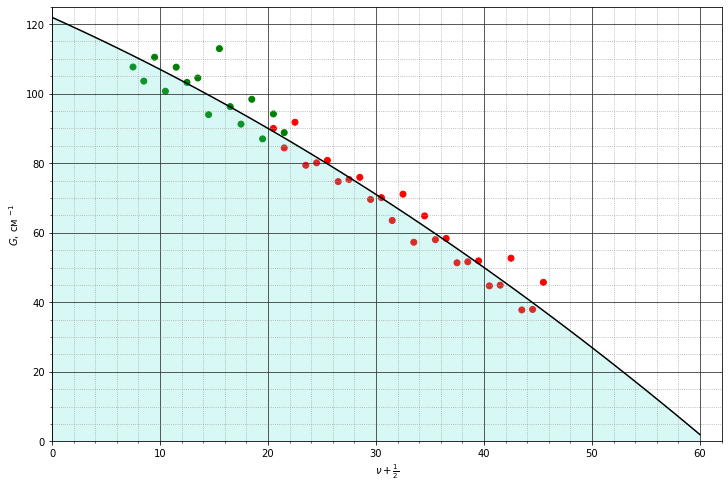

In [36]:
plt.figure(figsize=(12, 8))
ax = plt.axes()

maps = {0:'r', 1:'g'}

x = table_all['nu']+0.5
y = table_all['G']
color = table_all['Prog'].apply(lambda k: maps[k])

f3 = lambda x, a, b, c: a*x*x + b*x + c
popt, pcov = curve_fit(f3, x, y)

xs = np.linspace(0, 60)
ys = f3(xs, *popt)

plt.scatter(x, y, c=color)
plt.plot(xs, ys, color='k')
plt.ylim(0, 125)
plt.xlim(0, 62)
plt.fill_between(xs, [0 for _ in ys], ys, color='turquoise', alpha=0.2)

a, b, c = popt
da = np.sqrt(pcov[0][0])
db = np.sqrt(pcov[1][1])
dc = np.sqrt(pcov[2][2])
root = np.sqrt(b**2 - 4*a*c)
droot = sq_sum(2*b*db, sq_sum(da/a, dc/c)*4*a*c)/(2*root)
x0 = (-b - root)/(2*a)
dx0 = sq_sum(da/a, sq_sum(db, droot)/(b+root))*x0
D3 = a*x0**3/3 + b*x0**2/2 + c*x0
dD3 = sq_sum(sq_sum(da/a, dx0/x0)*a*x0**3/3, sq_sum(db/b, dx0/x0)*b*x0**2/2, sq_sum(dc/c, dx0/x0)*c*x0)
goals.add('D3', D3, dD3)
print(D3)

# props = dict(boxstyle='round', facecolor='#ef21c8', alpha=0.6)
# text = """$v_{gr} = {T} \\pm {d_T} $см$^{p}$
# """.format(
#     T = round(popt[0]), d_T=round(np.sqrt(pcov[0][0])),
#     p=r'{-1}', gr=r'{гр}'
# )
# plt.text(0.15, 0.25, text, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

# Add grid (very nice looking one :D)
from matplotlib.ticker import MultipleLocator
plt.grid(which='major', color='#323232', linestyle='-')
plt.grid(which='minor', color='#a4a4a4', linestyle=':')
mlx = MultipleLocator(2)
ax.xaxis.set_minor_locator(mlx) 
mly = MultipleLocator(5)
ax.yaxis.set_minor_locator(mly)

plt.xlabel(r'$\nu + \frac{1}{2}$')
plt.ylabel('$G$, см $^{-1}$')
plt.savefig('filled area.jpg')

$$
U(r-r_e) = D_e \Big(1 - e^{-\beta(r-r_e)} \Big)^2
$$

4295.166993247257  4055.6665650286977  4079.9655721495706  2.991315594922237  1.9093181271419342


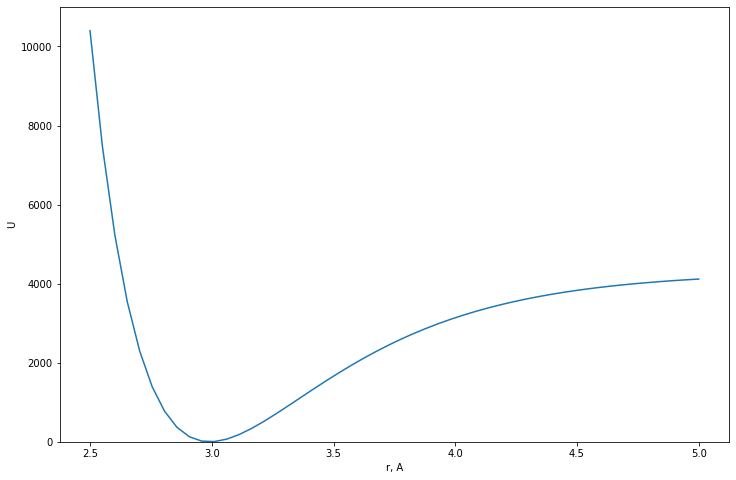

In [37]:
f4 = lambda r, D, omega, re = 3: (D+omega/2)*(1 - np.exp(-(0.970347*omega/np.sqrt(D + omega/2))*(r-re)))**2
f5 = lambda r, D, beta, re = 3: (D)*(1 - np.exp(-beta*(r-re)))**2

U = v_max - nu00 + 130/2
De = 4365

beta = 0.970347 * 130 / (De**0.5)
re = 2.67+1/beta*np.log(1+np.sqrt(U/De))

xs = np.linspace(2.5, 5)
# ys = f4(xs, 4050, 130)
ys = f5(xs, 4300, beta, re)



plt.figure(figsize=(12, 8))

plt.plot(xs, ys)
# plt.hlines(0, 2.5, 5, colors='k')
plt.ylim(0, 11e3)
plt.xlabel('r, A')
plt.ylabel('U')

print(D1, D2, D3, re, beta, sep='  ')

plt.savefig('Morse.jpg')

## Итоговая таблица полученных результатов
Таблица с полученными константами, найденными ранее.

Есть три категории:
- Сплошной спектр
- Квадратичная экстраполяция
- Линейная экстраполяция

In [38]:
goals

v_max 18754.688672167937 0
omega1 128.77675457578508 1.9524593683740872
chi1 128.77675457578508 0.00016295550878005525
D1 4295.166993247257 65.12152827216822
T2 15731.037149165173 4.789800323190421
omega2 130.70728385391837 0.39718872832287094
chi2 0.007628957225545305 3.361614172795207e-05
nu00 15689.140791092132 4.793915608092381
nugr 19744.80735612083 474.24164320188055
D2 4055.6665650286977 474.26587245307593
D3 4079.9655721495706 6973.919681087714